# Imports

In [ ]:
'''
******************************************************************************

Kaggle's web for dataset
    https://www.kaggle.com/datasets/uciml/news-aggregator-dataset
UCI dataset
    https://archive.ics.uci.edu/ml/datasets/News+Aggregator
Script adapted from Original example:
    https://developer.nvidia.com/blog/faster-text-classification-with-naive-bayes-and-gpus/

Definiciones:
    Multinomial: https://es.wikipedia.org/wiki/Distribuci%C3%B3n_multinomial
    Bernoulli: https://es.wikipedia.org/wiki/Distribuci%C3%B3n_Bernoulli
    Gaussiana: https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal
    Categórica: https://es.wikipedia.org/wiki/Distribuci%C3%B3n_categ%C3%B3rica
    Binomial: https://es.wikipedia.org/wiki/Distribuci%C3%B3n_binomial

    https://medium.com/datos-y-ciencia/algoritmos-naive-bayes-fudamentos-e-implementaci%C3%B3n-4bcb24b307f
    https://towardsdatascience.com/tf-idf-simplified-aba19d5f5530
'''


In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB as GaussianNB_sk
from sklearn.naive_bayes import BernoulliNB as BernoulliNB_sk
from sklearn.naive_bayes import CategoricalNB as CategoricalNB_sk
from sklearn.naive_bayes import MultinomialNB as MultinomialNB_sk
from sklearn.naive_bayes import ComplementNB as ComplementNB_sk

# Loading News Aggregator dataset

In [5]:
# Carga el dataset
dataset=pd.read_csv('uci-news-aggregator.csv')
# Muestra las primeras 3 filas
dataset.head(3)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550



Then we check the class distribution...

In [3]:
# Cambia los valores de la columna CATEGORY
# business; technology; entertainment; health = medicine
dataset['CATEGORY'] = dataset.CATEGORY.map({ 'b': 1, 't': 2, 'e': 3, 'm': 4 })
dataset.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [14]:
# Class distribution
dataset['CATEGORY'].value_counts()

CATEGORY
3    152469
1    115967
2    108344
4     45639
Name: count, dtype: int64

...split into training and test datasets...

In [16]:
Y, X = dataset['CATEGORY'], dataset['TITLE']
le = LabelEncoder()
y = le.fit_transform(Y)

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

...and check the sparsity of the data

In [20]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)

# Print sparsity of train and test
print(x_train.nnz / (x_train.shape[0] * x_train.shape[1])*100)
print(x_test.nnz / (x_test.shape[0] * x_test.shape[1])*100)
print(type(x_train))

0.013528807518777329
0.013420353576295799
<class 'scipy.sparse._csr.csr_matrix'>


# Gaussian NB

Transform the text through a TF-IDF vectorizer and iterate through the dataset to do multiple partial fits of Gaussian naive Bayes.

In [21]:
vec1 = TfidfVectorizer(stop_words='english', ngram_range=(1,3), min_df=5)
x_train1 = vec1.fit_transform(X_train_text)
x_test1 = vec1.transform(X_test_text)


In [22]:
print(x_train1.shape)
print(type(x_train1))

(316814, 101709)
<class 'scipy.sparse._csr.csr_matrix'>


In [23]:
def dataset_traversal(X, Y, partial_function):
    chunk_size = 5000
    classes = np.unique(Y)
    lower = 0
    for upper in iter(range(chunk_size, X.shape[0], chunk_size)):
        partial_function(X[lower:upper], Y[lower:upper], classes)
        lower = upper
    partial_function(X[upper:], Y[upper:], classes)

gnb = GaussianNB_sk()
%time dataset_traversal(x_train1,\
                        y_train,\
                        lambda x, y, c: gnb.partial_fit(x.toarray(), y, c))

%time dataset_traversal(x_test1,\
                        y_test,\
                        lambda x, y, c: print(gnb.score(x.toarray(), y)))


CPU times: user 6min 54s, sys: 5min 7s, total: 12min 2s
Wall time: 14min
0.8976
0.889
0.8896
0.8916
0.8928
0.8986
0.8922
0.8874
0.8824
0.894
0.896
0.8938
0.8858
0.8886
0.895
0.8976
0.8958
0.8916
0.8888
0.898
0.8958
0.8925619834710744
CPU times: user 3min 51s, sys: 4min 8s, total: 7min 59s
Wall time: 9min 13s


# Bernoulli + CountVectorizer


In the Bernoulli variant, the feature vector is binarized. That's why using a CountVectorizer transformer is useful: You're more interested in the presence of the word rather than it's frequency.

In [24]:
vec2 = CountVectorizer(stop_words='english', binary=True, ngram_range=(1,3))

x_train2 = vec2.fit_transform(X_train_text)
x_test2 = vec2.transform(X_test_text)

bnb = BernoulliNB_sk()
%time bnb.fit(x_train2, y_train)
%time print(f'Score para BN Bernoulli {bnb.score(x_test2, y_test)}')

CPU times: user 409 ms, sys: 144 ms, total: 552 ms
Wall time: 548 ms
Score para BN Bernoulli 0.8704133327020501
CPU times: user 215 ms, sys: 72.1 ms, total: 287 ms
Wall time: 281 ms


# TF-IDF + Multinomial

Transform the text through a TF-IDF vectorizer, and run a multinomial naive Bayes model.

In [25]:
vec3 = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
x_train3 = vec3.fit_transform(X_train_text)
x_test3 = vec3.transform(X_test_text)

mnb = MultinomialNB_sk()
%time mnb.fit(x_train3, y_train)
%time print(f'Score para BN Multinomial {mnb.score(x_test3, y_test)}')

CPU times: user 348 ms, sys: 299 ms, total: 647 ms
Wall time: 646 ms
Score para BN Multinomial 0.9338194214289096
CPU times: user 66.3 ms, sys: 9.62 ms, total: 75.9 ms
Wall time: 74.8 ms


# CountVectorizer + Complement
Complement naive Bayes models should be coupled with a CountVectorizer to have the best results.

CATEGORY
3    0.360943
1    0.274531
2    0.256485
4    0.108042
Name: count, dtype: float64


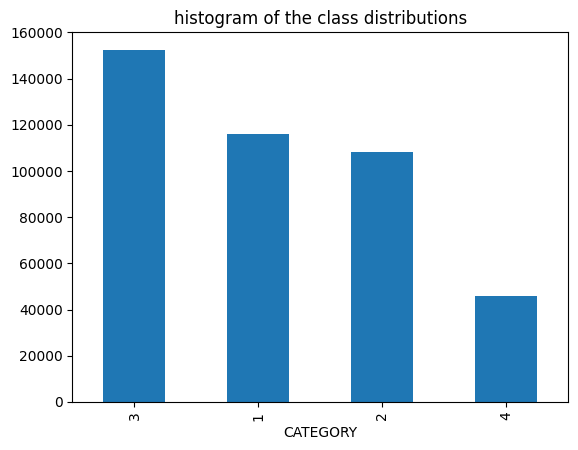

In [27]:
# First let's visualize the class imbalance

dataset['CATEGORY'].value_counts().plot(kind='bar', title='histogram of the class distributions')
print(dataset['CATEGORY'].value_counts() / len(dataset))

In [28]:
vec4 = CountVectorizer(stop_words='english', ngram_range=(1,3))
x_train4 = vec4.fit_transform(X_train_text)
x_test4 = vec4.transform(X_test_text)

cnb = ComplementNB_sk()
%time cnb.fit(x_train4, y_train)
%time print(f'Score para BN Complement {cnb.score(x_test4, y_test)}')

CPU times: user 482 ms, sys: 308 ms, total: 790 ms
Wall time: 786 ms
Score para BN Complement 0.9540646749680413
CPU times: user 68.2 ms, sys: 25.2 ms, total: 93.3 ms
Wall time: 91.8 ms


# Categorical

To transform the text to categorical data, you can apply a clustering technique to merge the terms that are similar.

To create these clusters, you could reuse a previously fitted naive Bayes model but just for the purpose of clustering those words.

## Preprocessing

In [29]:
# First fit a TfIdf on the train dataset
tfidfvec = TfidfVectorizer(stop_words='english', min_df=10)
x_train5 = tfidfvec.fit_transform(X_train_text)

# Fit a Multinomial on the TdIdf data
mnb2 = MultinomialNB_sk().fit(x_train5, y_train)


In [30]:
# Use a KMeans algorithm to cluster on what the Multinomial NB learned of the TfIdf.
# This means that the words that contribute similarly to a category will be clustered together
km = KMeans(n_clusters=1000, random_state=1)
feature_to_cluster = km.fit_predict(mnb2.feature_log_prob_.T)

print(type(feature_to_cluster))         # nparray
print(type(mnb2.feature_log_prob_.T) )   # nparray
print((mnb2.feature_log_prob_.T).shape)  # (14967,4)
print((feature_to_cluster).shape)       # (14967,)
print(feature_to_cluster)               # indica el cluster al que pertenece cada elemento

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(14967, 4)
(14967,)
[462 924 543 ... 104 824 801]


In [31]:
feats2cluster = OneHotEncoder().fit_transform(feature_to_cluster.reshape(-1, 1))

print(type(feats2cluster))  # <class 'scipy.sparse._csr.csr_matrix'>
print(feats2cluster.shape)  # (14967, 1000)


<class 'scipy.sparse._csr.csr_matrix'>
(14967, 1000)


In [32]:
feats2cluster=feats2cluster.toarray()
print(feats2cluster.shape)  # (14967, 1000)
print(feats2cluster)

(14967, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [33]:
# Print statistics on the repartition of the words in the clusters
print(pd.Series(feats2cluster.sum(axis=0)).describe())
print(pd.Series(feats2cluster.sum(axis=0)))

count    1000.000000
mean       14.967000
std        17.261804
min         1.000000
25%         6.000000
50%        11.000000
75%        17.250000
max       151.000000
dtype: float64
0       6.0
1      21.0
2       7.0
3      16.0
4      35.0
       ... 
995    21.0
996    18.0
997     8.0
998     3.0
999    21.0
Length: 1000, dtype: float64


Here each cluster holds in average around 15 words

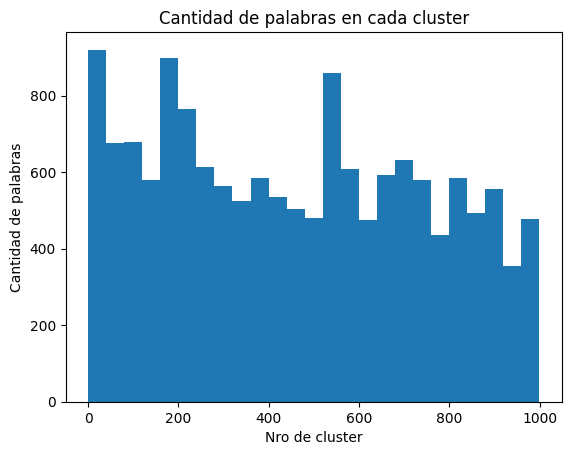

In [34]:
# Lets plot the repartition of the words in each cluster
# And print the words in a few clusters
plt.hist(feature_to_cluster, bins='auto')
plt.title('Cantidad de palabras en cada cluster')
plt.xlabel('Nro de cluster')
plt.ylabel('Cantidad de palabras')
plt.show()


In [35]:
print(len(tfidfvec.vocabulary_))  # 14967
print(tfidfvec.vocabulary_)

14967
{'apple': 1081, 'agrees': 765, 'pay': 9784, '450m': 322, 'settlement': 11957, 'ebook': 4522, 'price': 10370, 'fixing': 5370, 'case': 2444, 'movie': 8866, 'review': 11293, 'transformers': 13711, 'age': 746, 'extinction': 5024, 'saved': 11697, 'veterans': 14273, 'mark': 8290, '10': 12, 'record': 10903, 'stores': 12837, 'metro': 8546, 'phoenix': 9945, 'zenimax': 14942, 'drags': 4338, 'oculus': 9313, 'vr': 14411, 'court': 3361, 'rift': 11361, 'headset': 6341, 'dispute': 4147, 'game': 5725, 'thrones': 13494, 'burning': 2229, 'questions': 10665, 'finale': 5294, 'durable': 4446, 'goods': 5951, 'orders': 9459, 'jump': 7357, 'march': 8267, 'french': 5604, 'market': 8293, 'lower': 8080, 'plunges': 10110, 'jeopardy': 7252, 'champ': 2567, 'unseated': 14084, '11': 37, 'winning': 14697, 'streak': 12861, 'women': 14746, 'comic': 2991, 'protest': 10515, 'harassment': 6250, 'nadine': 8963, 'gordimer': 5961, 'nobel': 9159, 'prize': 10403, 'author': 1334, 'apartheid': 1045, 'dies': 4016, '90': 478,

In [36]:
tfidfvec_pd=pd.DataFrame(tfidfvec.vocabulary_.keys(), index=(tfidfvec.vocabulary_).values(), columns=['words'])
print(tfidfvec_pd.shape)
print(tfidfvec_pd.head())

(14967, 1)
            words
1081        apple
765        agrees
9784          pay
322          450m
11957  settlement


In [37]:
#%%   cell 22.2  vemos cómo ubicamos la posición de cada palabra en la consulta np.where
print(np.where(feature_to_cluster == 127))
print((np.where(feature_to_cluster == 632)))
print((np.where(feature_to_cluster == 127))[0])
print((np.where(feature_to_cluster == 127))[0][0])

(array([ 3483,  5216,  8085,  8263,  9437, 11605, 11946, 12869, 14106,
       14589]),)
(array([ 7124, 12365]),)
[ 3483  5216  8085  8263  9437 11605 11946 12869 14106 14589]
3483


In [38]:
#%%    cell 22.3         ahora accedemos a la palabra a través de su posición
print(tfidfvec_pd.iloc[ (np.where(feature_to_cluster == 127)[0][0]),:])
print("\n")
print(tfidfvec_pd.iloc[(np.where(feature_to_cluster == 632)[0][0]),:])

words    wheelan
Name: 14615, dtype: object


words    correction
Name: 3304, dtype: object


In [39]:
# For Categorical Naive Bayes, the count of words is transformed into a count of cluster
vocab = tfidfvec.vocabulary_
countvec = CountVectorizer(stop_words='english')
countvec.vocabulary_ = vocab

x_train6 = countvec.transform(X_train_text)
x_test6 = countvec.transform(X_test_text)
print(x_train6.shape)
print(feats2cluster.shape)

x_train_cluster = (x_train6 @ feats2cluster)
x_test_cluster = (x_test6 @ feats2cluster)

print(type(x_train_cluster))
print(x_train_cluster.shape)
print(x_train_cluster)

(316814, 14967)
(14967, 1000)
<class 'numpy.ndarray'>
(316814, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [41]:
# For each cluster we will have:
# - 0: absence of those wprds.
# - 1: presence of those words
# - 2: multiple presence of those words (2+)

x_train_cluster[x_train_cluster > 2] = 2
x_test_cluster[x_test_cluster > 2] = 2

Little hack to make sure that if a cluster's max number is 1 in training, it is also 1 in testing

In [42]:
print(np.where(x_train_cluster.max(0) == 1))

(array([ 63,  82,  99, 104, 108, 119, 123, 145, 150, 161, 164, 177, 187,
       196, 204, 244, 254, 256, 311, 314, 315, 328, 339, 346, 356, 359,
       360, 367, 374, 376, 378, 383, 394, 395, 397, 404, 426, 430, 432,
       434, 456, 471, 480, 497, 509, 510, 535, 546, 547, 550, 587, 590,
       591, 594, 601, 609, 627, 630, 652, 697, 701, 715, 731, 732, 734,
       737, 747, 771, 787, 794, 795, 796, 798, 800, 803, 812, 813, 815,
       840, 844, 846, 865, 868, 882, 898, 900, 913, 929, 936, 938, 946,
       947, 948, 952, 955, 980, 987]),)


In [44]:
max_one = np.where(x_train_cluster.max(0) == 1)[0]
print(len(max_one))       # 97
print(max_one.shape)

for cluster in max_one:
    samples = (x_test_cluster[:, cluster] > 1)   # nparray tipo máscara, los elementos son True-False
    samples = np.where(samples)[0]
    x_test_cluster[samples, cluster] = 1

97
(97,)


## Categorical model training

Now that the preprocessing is done we can train the Categorical model and see how it performs on these clusters

In [45]:
%time cnb = CategoricalNB_sk().fit(x_train_cluster, y_train)
%time print(f'Score de Categorical NB {cnb.score(x_test_cluster, y_test)}')

CPU times: user 27.4 s, sys: 1.09 s, total: 28.5 s
Wall time: 29.5 s
Score de Categorical NB 0.9271720089010937
CPU times: user 19 s, sys: 326 ms, total: 19.4 s
Wall time: 23.8 s


# Performance gain
## Gráfico de comparación entre los tiempos de procesamiento sobre los mismos modelos de la CPU con sklearn y la GPU de Nvidia con cuML


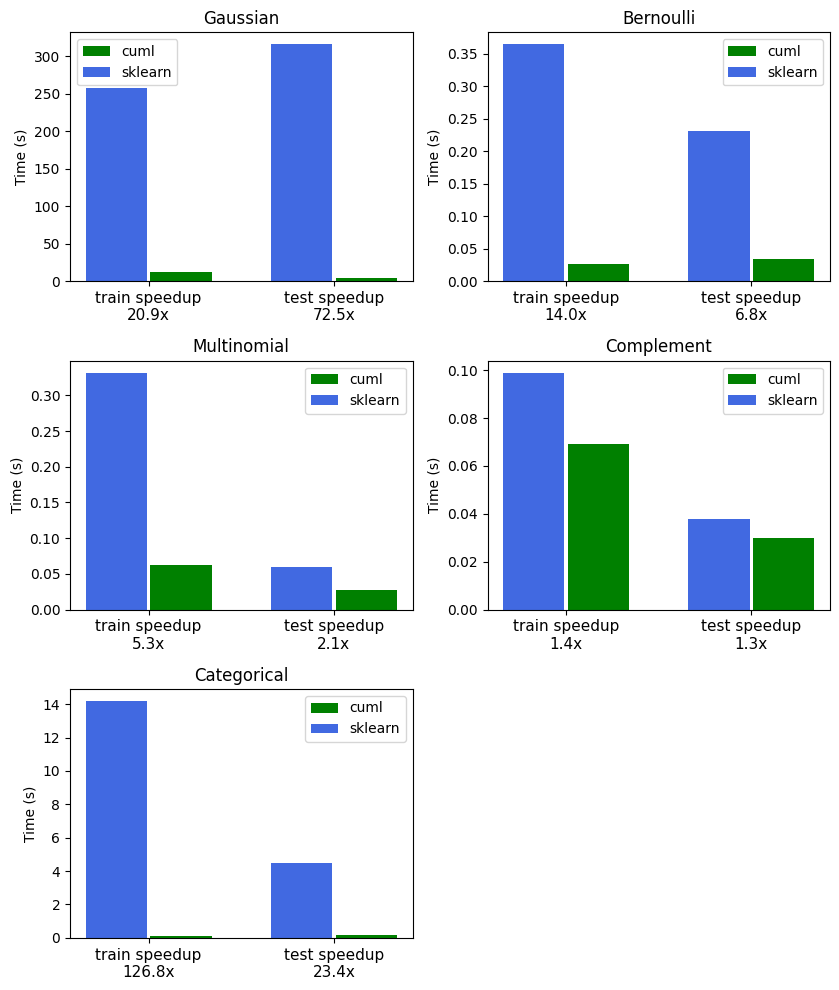

In [46]:
variants = ['Gaussian', 'Bernoulli', 'Multinomial', 'Complement', 'Categorical']
time_training_cuml = np.array([12300,  26,  63,  69,  112]) / 1000
time_testing_cuml  = np.array([4360,   34,  28,  30,  193])/ 1000
time_training_sk   = np.array([257000, 365, 332, 99, 14200])/ 1000
time_testing_sk    = np.array([316000, 231, 59,  38,  4510])/ 1000
training_gain = time_training_sk / time_training_cuml
testing_gain = time_testing_sk / time_testing_cuml

x = np.arange(2)  # the label locations
width = 0.33  # the width of the bars
fig = plt.figure(figsize=(8.5,10))

for i in range(5):
    ax = plt.subplot(3,2,i+1)
    ax.bar(x[0] + width/2 + 0.01, time_training_cuml[i], width, color='green')
    ax.bar(x[0] - width/2 - 0.01, time_training_sk[i], width, color='royalblue')
    ax.bar(x[1] + width/2 + 0.01, time_testing_cuml[i], width, color='green')
    ax.bar(x[1] - width/2 - 0.01, time_testing_sk[i], width, color='royalblue')

    ax.set_ylabel('Time (s)')
    ax.set_title(variants[i])
    ax.set_xticks(x)
    ax.set_xticklabels(["train speedup\n{:.1f}x".format(training_gain[i]),
                        "test speedup\n{:.1f}x".format(testing_gain[i])],
                      fontdict={'fontsize': 11,})
    ax.legend(['cuml', 'sklearn'])

fig.tight_layout()

plt.show()